In [146]:
# coding=utf-8
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate, optimize
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate, optimize
from scipy.integrate import odeint
import numpy as np
import pandas as pd
import time

df = pd.read_csv('covid_china.csv', index_col=0)

In [147]:
# current infected
df_i = df['currentConfirmedCount'].iloc[:80]
# current suspected
df_p = df['currentSuspectedCount'].iloc[:80]
# current isolated (exposed)
df_q = df['currentQuarantined'].iloc[:80]
# death count
df_d = df['deadCount'].iloc[:80]
# recovered count
df_r = df['curedCount'].iloc[:80]

Plist = df_p.to_numpy()
Qlist = df_q.to_numpy()
Ilist = df_i.to_numpy()
Rlist = df_r.to_numpy()
Dlist = df_d.to_numpy()

global Plist, Qlist, Ilist, Rlist, Dlist;

In [74]:
# set up model
def SEQPIRD_model(Y,t,beta,lambd,delta,kappa,gamma,epilson):
    S,E,Q,P,I,R,D = Y
    N=sum(Y)
    dS = - beta * S * I / N 
    dE = beta * S * I / N  - lambd * E
    dQ = lambd * E - delta * Q
    dP = delta * Q - kappa * P
    dI = kappa * P - gamma * I - epilson * I
    dR = gamma * I
    dD = epilson * I
    return dS,dE,dQ,dP,dI,dR,dD


# show all SEIR, calculate parameters
def fit_odeint_SEQPIRD(t,beta,lambd,delta,kappa,gamma,epilson):
    return integrate.odeint(SEQPIRD_model, ini, t, args=(beta,lambd,delta,kappa,gamma,epilson))

# loss function
def loss(para):

    beta=para[0]
    lambd=para[1]
    delta=para[2]
    kappa=para[3]
    gamma=para[4]
    epilson=para[5]
    
    T= np.arange(0,len(Ilist))
    I0 = Ilist[0]
    # take a guess on the expected population
    P0 = Plist[0]
    Q0 = Qlist[0]
    E0 = Q0/3
    I0 = Ilist[0]
    R0 = Rlist[0]
    D0 = Dlist[0]
    population = 200000
    S0 = population - P0 - Q0 - E0 - I0 - R0 - D0

    # initiate the model
    ini = [S0, E0, Q0, P0, I0, R0, D0] 

    fit_seqpird = integrate.odeint(SEQPIRD_model, ini, T, args=(beta,lambd,delta,kappa,gamma,epilson))
    diffI = fit_seqpird[:,4]-Ilist
    diffD = fit_seqpird[:,6]-Dlist
    fitloss=1000*np.dot(diffI.T,diffI)+100*np.dot(diffD.T,diffD)
    #fitloss=np.dot(diffI.T,diffI)
    #fitloss=np.dot(diffR.T,diffR)
    return fitloss


# time span
T= np.arange(0,len(Ilist))

# set up initial values
P0 = Plist[0]
Q0 = Qlist[0]
E0 = Q0/3
I0 = Ilist[0]
R0 = Rlist[0]
D0 = Dlist[0]
population = 200000
S0 = population - P0 - Q0 - E0 - I0 - R0 - D0

# initiate the model
ini = [S0, E0, Q0, P0, I0, R0, D0] 



# optimize the model
methods=['Nelder-Mead','SLSQP','L-BFGS-B','COBYLA','Powell']

# find the best parameter, set up the initial values
beta = 8
lambd = 0.7
delta = 0.4
kappa = 0.2
#sigma=0.9
gamma = 0.8
epilson = 0.5
para=[beta,lambd,delta,kappa,gamma,epilson]

method_name = methods[2]
# bounds are set to aviod outliers that can affect the parameters too much
para= optimize.minimize(loss, para, method=method_name,bounds=[(0,8),(0,1),(0,1),(0,1),(0,1),(0,1)])


# get the fitting data of model
popt=para.x
# theoritical data with future expectation
fitted = fit_odeint_SEQPIRD(np.array(list(range(1,len(Ilist)+6))), *popt)

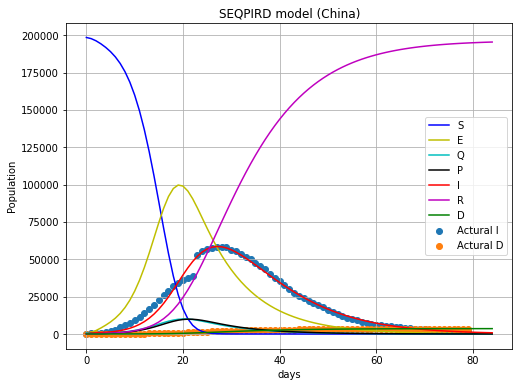

In [75]:
plt.figure(1, figsize=(8,6))
plt.plot(np.arange(0,len(fitted)),fitted[:,0],'b-',label ='S')
plt.plot(np.arange(0,len(fitted)),fitted[:,1],'y-',label = 'E')
plt.plot(np.arange(0,len(fitted)),fitted[:,2],'c-',label = 'Q')
plt.plot(np.arange(0,len(fitted)),fitted[:,3],'k-',label = 'P')
plt.plot(np.arange(0,len(fitted)),fitted[:,4],'r-',label = 'I')
plt.plot(np.arange(0,len(fitted)),fitted[:,5],'m-',label = 'R')
plt.plot(np.arange(0,len(fitted)),fitted[:,6],'g-',label = 'D')

plt.scatter(T,Ilist,label='Actural I')
plt.scatter(T,Dlist,label='Actural D')
plt.xlabel('days')
plt.ylabel('Population')
plt.grid()
plt.title('SEQPIRD model (China)')
plt.legend()

In [76]:
popt

array([2.41241774e+00, 1.02239193e-01, 1.00000000e+00, 1.00000000e+00,
       1.19540018e-01, 2.18679246e-03])

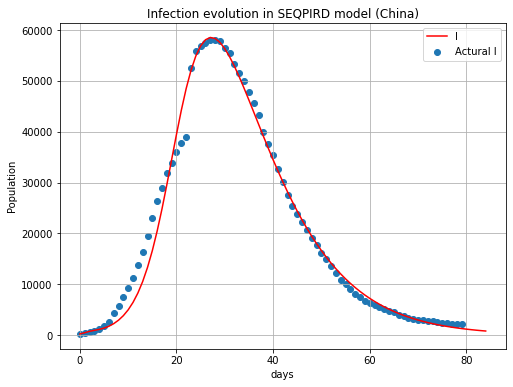

In [77]:
plt.figure(1, figsize=(8,6))
plt.plot(np.arange(0,len(fitted)),fitted[:,4],'r-',label = 'I')
plt.scatter(T,Ilist,label='Actural I')
plt.xlabel('days')
plt.ylabel('Population')
plt.grid()
plt.title('Infection evolution in SEQPIRD model (China)')
plt.legend()

In [78]:
r2_i = df['currentConfirmedCount'].iloc[:85]

from sklearn.metrics import r2_score
r2_score(r2_i, fitted[:,4])

0.9852964882039003

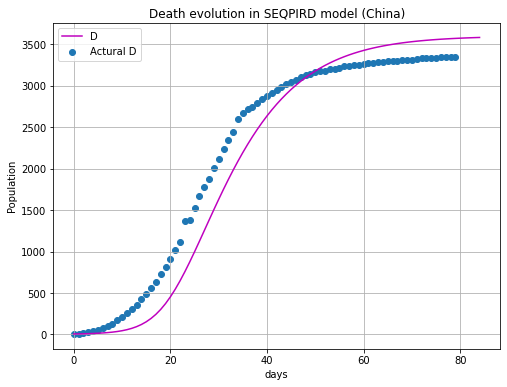

In [79]:
plt.figure(1, figsize=(8,6))
plt.plot(np.arange(0,len(fitted)),fitted[:,6],'m-',label = 'D')
plt.scatter(T,Dlist,label='Actural D')
plt.xlabel('days')
plt.ylabel('Population')
plt.grid()
plt.title('Death evolution in SEQPIRD model (China)')
plt.legend()

In [34]:
result = fitted[:,4]
predict = result[80:85]

r2_score(r2_i[80:85], predict)

-6197.001854113624

## 60-80 days

In [148]:
infect = Ilist[60:80]
suspect = Plist[60:80] 
quarantine = Qlist[60:80]
recover = Rlist[60:80]
death = Dlist[60:80]

In [149]:
# set up model
def SEQPIRD_model(Y,t,beta,lambd,delta,kappa,gamma,epilson):
    S,E,Q,P,I,R,D = Y
    N=sum(Y)
    dS = - beta * S * I / N 
    dE = beta * S * I / N  - lambd * E
    dQ = lambd * E - delta * Q
    dP = delta * Q - kappa * P
    dI = kappa * P - gamma * I - epilson * I
    dR = gamma * I
    dD = epilson * I
    return dS,dE,dQ,dP,dI,dR,dD


# show all SEIR, calculate parameters
def fit_odeint_SEQPIRD(t,beta,lambd,delta,kappa,gamma,epilson):
    return integrate.odeint(SEQPIRD_model, ini, t, args=(beta,lambd,delta,kappa,gamma,epilson))

# loss function
def loss(para):

    beta=para[0]
    lambd=para[1]
    delta=para[2]
    kappa=para[3]
    gamma=para[4]
    epilson=para[5]
    
    T= np.arange(0,len(infect))
    I0 = infect[0]
    # take a guess on the expected population
    P0 = suspect[0]
    Q0 = quarantine[0]
    E0 = Q0/3
    R0 = recover[0]
    D0 = death[0]
    population = 200000
    S0 = population - P0 - Q0 - E0 - I0 - R0 - D0

    # initiate the model
    ini = [S0, E0, Q0, P0, I0, R0, D0] 

    fit_seqpird = integrate.odeint(SEQPIRD_model, ini, T, args=(beta,lambd,delta,kappa,gamma,epilson))
    diffI = fit_seqpird[:,4]-Ilist[60:80]
    diffD = fit_seqpird[:,6]-Dlist[60:80]
    fitloss=1000*np.dot(diffI.T,diffI)+100*np.dot(diffD.T,diffD)
    return fitloss



T= np.arange(0,len(infect))
I0 = infect[0]
P0 = suspect[0]
Q0 = quarantine[0]
E0 = Q0/3
R0 = recover[0]
D0 = death[0]
population = 200000
S0 = population - P0 - Q0 - E0 - I0 - R0 - D0

# initiate the model
ini = [S0, E0, Q0, P0, I0, R0, D0] 



# optimize the model
methods=['Nelder-Mead','SLSQP','L-BFGS-B','COBYLA','Powell']

# find the best parameter, set up the initial values
beta = 8
lambd = 0.7
delta = 0.4
kappa = 0.2
#sigma=0.9
gamma = 0.8
epilson = 0.5
para=[beta,lambd,delta,kappa,gamma,epilson]

method_name = methods[2]
# bounds are set to aviod outliers that can affect the parameters too much
para= optimize.minimize(loss, para, method=method_name,bounds=[(0,8),(0,1),(0,1),(0,1),(0,1),(0,1)])


# get the fitting data of model
popt=para.x
# theoritical data with future expectation
fitted = fit_odeint_SEQPIRD(np.array(list(range(1,len(infect)+6))), *popt)

In [150]:
popt

array([7.38533257e+00, 1.17463374e-01, 1.38631584e-02, 1.11443196e-02,
       7.35400903e-02, 1.26199345e-03])

In [151]:
r2_i = df['currentConfirmedCount'].iloc[60:85]
r2_d = df['deadCount'].iloc[60:85]
infect = fitted[:,4]
death = fitted[:,6]

from sklearn.metrics import r2_score
r2_score(r2_i, fitted[:,4])

0.997669254176186

In [152]:
r2_score(r2_d, fitted[:,6])

0.9872148542685

In [153]:
r2_score(r2_i[-5:], infect[-5:])

-5.714441671472263

In [154]:
r2_score(r2_d[20:25], death[20:25])

-5.337035659430559

In [159]:
infect[-5:]

array([2144.83425135, 2129.52921144, 2125.45983288, 2131.83373771,
       2147.89037784])

In [155]:
infect[20:25]

array([2144.83425135, 2129.52921144, 2125.45983288, 2131.83373771,
       2147.89037784])

In [156]:
r2_i[20:25]

Date
09/04/2020    2122
10/04/2020    2085
11/04/2020    2113
12/04/2020    2101
13/04/2020    2083
Name: currentConfirmedCount, dtype: int64

In [157]:
death[20:25]

array([3348.73872888, 3351.4346139 , 3354.11835871, 3356.80363935,
       3359.50315188])

In [158]:
r2_d[20:25]

Date
09/04/2020    3345
10/04/2020    3349
11/04/2020    3349
12/04/2020    3351
13/04/2020    3351
Name: deadCount, dtype: int64

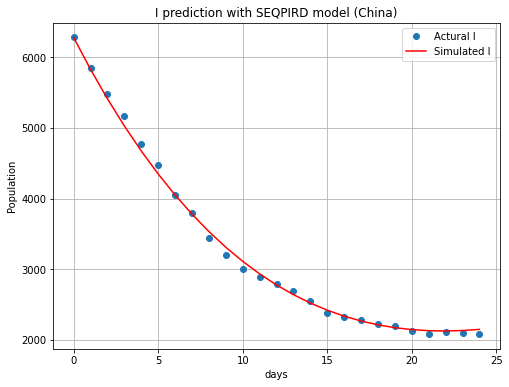

In [95]:
plt.figure(1, figsize=(8,6))
plt.plot(np.arange(0,len(fitted)),r2_i,'o',label='Actural I')
#plt.plot(np.arange(0,len(fitted)),fitted[:,0],'b-',label ='S')
#plt.plot(np.arange(0,len(fitted)),fitted[:,1],'y-',label = 'E')
#plt.plot(np.arange(0,len(fitted)),fitted[:,2],'c-',label = 'Q')
#plt.plot(np.arange(0,len(fitted)),fitted[:,3],'k-',label = 'P')
plt.plot(np.arange(0,len(fitted)),fitted[:,4],'r-',label = 'Simulated I')
#plt.plot(np.arange(0,len(fitted)),fitted[:,5],'m-',label = 'R')
#plt.plot(np.arange(0,len(fitted)),fitted[:,6],'g-',label = 'D')


plt.xlabel('days')
plt.ylabel('Population')
plt.grid()
plt.title('I prediction with SEQPIRD model (China)')
plt.legend()

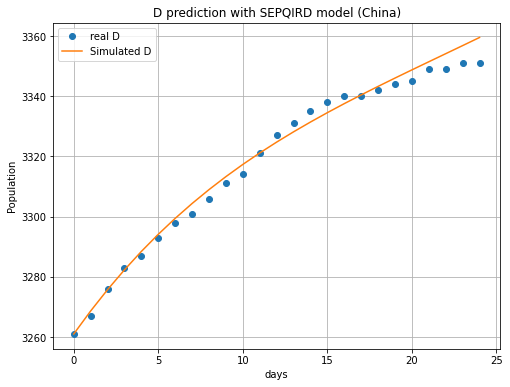

In [96]:
plt.figure(1, figsize=(8,6))

plt.plot(np.arange(0,len(fitted)), r2_d,'o',label='real D')
plt.plot(np.arange(0,len(fitted)),fitted[:,6],label='Simulated D')
plt.grid()
plt.xlabel('days')
plt.ylabel('Population')
plt.title('D prediction with SEPQIRD model (China)')
plt.legend()
plt.show()

## SEIR model test

In [125]:
df_china = pd.read_csv('covid_china.csv', index_col=0)

# current infected
df_i = df_china['currentConfirmedCount'].iloc[60:80]
# death count
df_d = df_china['deadCount'].iloc[60:80]
# recovered count
df_r = df_china['curedCount'].iloc[60:80]

Ilist = df_i.to_numpy()
Rlist = df_r.to_numpy()
Dlist = df_d.to_numpy()

global Ilist, Rlist, Dlist;

In [126]:
# Test with SEIR model
def SEIR_model(Y,t,beta,alpha,gamma):
    S,E,I,R = Y
    N=sum(Y)
    dS = - beta * S * I / N 
    dE = beta * S * I / N  - alpha* E
    dI = alpha * E - gamma * I
    dR = gamma * I
    return dS,dE,dI,dR

# show all SEIR, calculate parameters
def fit_odeint_SEIR(t,beta,alpha,gamma):
    return integrate.odeint(SEIR_model, ini, t, args=(beta,alpha,gamma))

# loss function
def loss(para):

    beta=para[0]
    alpha=para[1]
    gamma=para[2]
    
    T= np.arange(0,len(Ilist))
    I0 = Ilist[0]
    E0 = I0/3
    R0 = Rlist[0] + Dlist[0]
    population = 60e6
    S0 = population - E0 - I0 - R0
    ini = [S0, E0, I0, R0]


    fit_seir=integrate.odeint(SEIR_model, ini, T, args=(beta,alpha,gamma))
    diffI=fit_seir[:,2] - Ilist
    diffR=fit_seir[:,3] - Rlist - Dlist
    fitloss=1000*np.dot(diffI.T,diffI)+100*np.dot(diffR.T,diffR)
    #fitloss=np.dot(diffI.T,diffI)
    #fitloss=np.dot(diffR.T,diffR)
    return fitloss


# initiate the model
T= np.arange(0,len(Ilist)) ###### time span

I0 = Ilist[0]
E0 = I0*5
R0 = Rlist[0] + Dlist[0]
population = 60e6
S0 = population - E0 - I0 - R0
ini = [S0, E0, I0, R0] ### initiate the SEIR 



# optimize the model
methods=['Nelder-Mead','SLSQP','L-BFGS-B','COBYLA','Powell']

# find the best parameter
beta=5
alpha=0.2
gamma=0.1
para=[beta, alpha, gamma]

method_name = methods[2]
para= optimize.minimize(loss, para, method=method_name,bounds=[(0,5),(0,1),(0,1)])


# get the fitting data of SEIR
popt=para.x
# theoritical data with future expectation
fitted = fit_odeint_SEIR(np.array(list(range(1,len(Ilist)+6))), *popt)


In [127]:
r2_i = df_china['currentConfirmedCount'].iloc[60:85]
r2_d = df_china['deadCount'].iloc[60:85] + df_china['curedCount'].iloc[60:85]

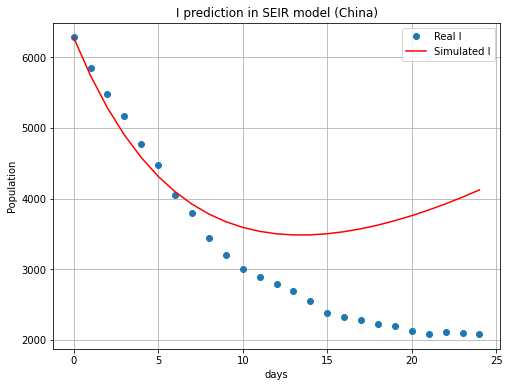

In [128]:
# plot the result
plt.figure(1, figsize=(8,6))
#plt.plot(np.arange(0,len(fitted)),fitted[:,0],'b-',label ='S')
#plt.plot(np.arange(0,len(fitted)),fitted[:,1],'y-',label = 'E')
plt.plot(np.arange(0,25),r2_i,'o',label='Real I')
plt.plot(np.arange(0,25),fitted[:,2],'r-',label = 'Simulated I')
#plt.plot(np.arange(0,len(fitted)),fitted[:,3],'g-',label = 'R')
#plt.plot(T,Ilist,label='Actural I')
plt.xlabel('days')
plt.ylabel('Population')
plt.title('I prediction in SEIR model (China)')
plt.legend()
plt.grid()
plt.show()

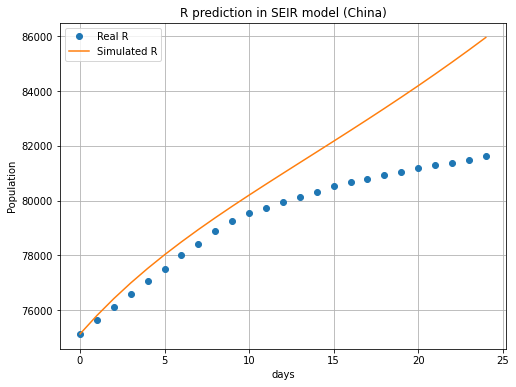

In [129]:
plt.figure(1, figsize=(8,6))
plt.plot(np.arange(0,len(fitted)),r2_d,'o',label='Real R')
plt.plot(np.arange(0,len(fitted)),fitted[:,3],label = 'Simulated R')

plt.xlabel('days')
plt.ylabel('Population')
plt.title('R prediction in SEIR model (China)')
plt.legend()
plt.grid()
plt.show()

In [130]:
from sklearn.metrics import r2_score
r2_score(r2_i, fitted[:,2])

0.3126477008368379

In [132]:
r2_score(r2_d, fitted[:,3])

-0.06226635054126928

In [133]:
infect = fitted[:,2]
removed = fitted[:,3]
r2_score(r2_i[20:25], infect[20:25])

-14479.452038612308

In [134]:
r2_score(r2_d[20:25], removed[20:25])

-592.3556002430414

## SIR model test

In [135]:
def SIR_model(Y,t,beta,gamma):
    S,I,R = Y
    N=sum(Y)
    dS = - beta * S * I / N 
    dI =  beta * S * I / N - gamma * I
    dR = gamma * I
    return dS,dI,dR

def fit_odeint_SIR(t,beta,gamma):
    return integrate.odeint(SIR_model, ini, t, args=(beta,gamma))

def loss(para):

    beta=para[0]
    gamma=para[1]
    
    T= np.arange(0,len(Ilist))
    I0 = Ilist[0]
    E0 = I0*5
    R0 = Rlist[0] + Dlist[0]
    population = 60e6
    S0=population - I0 - R0
    ini =[S0, I0, R0]

    fit_seir=integrate.odeint(SIR_model, ini, T, args=(beta,gamma))
    diffI=fit_seir[:,1] - Ilist
    diffR=fit_seir[:,2] - Rlist - Dlist
    fitloss=1000*np.dot(diffI.T,diffI)+100*np.dot(diffR.T,diffR)

    return fitloss


T= np.arange(0,len(Ilist))
I0 = Ilist[0]
R0 = Rlist[0] + Dlist[0]
population = 60e6
S0 = population - I0 - R0
ini = [S0, I0, R0]

beta=0.3
alpha=0.2
gamma=0.1
para=[beta, gamma]

method_name = methods[2]
para= optimize.minimize(loss, para, method='L-BFGS-B',bounds=[(0,5),(0,1)])

popt=para.x
fitted = fit_odeint_SIR(np.array(list(range(1,len(Ilist)+6))), *popt)

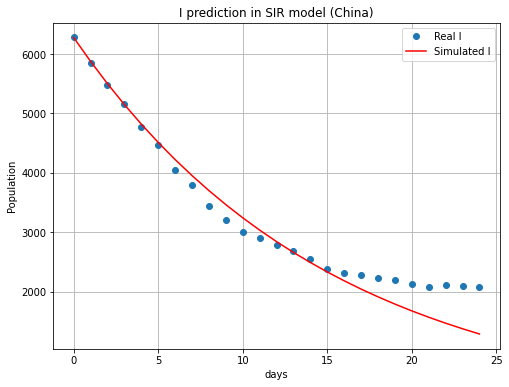

In [136]:
# plot the result
plt.figure(1, figsize=(8,6))
#plt.plot(np.arange(0,len(fitted)),fitted[:,0],'b-',label ='S')
#plt.plot(np.arange(0,len(fitted)),fitted[:,1],'y-',label = 'E')
plt.plot(np.arange(0,25),r2_i,'o',label='Real I')
plt.plot(np.arange(0,25),fitted[:,1],'r-',label = 'Simulated I')
#plt.plot(np.arange(0,len(fitted)),fitted[:,3],'g-',label = 'R')
#plt.plot(T,Ilist,label='Actural I')
plt.xlabel('days')
plt.ylabel('Population')
plt.title('I prediction in SIR model (China)')
plt.legend()
plt.grid()
plt.show()

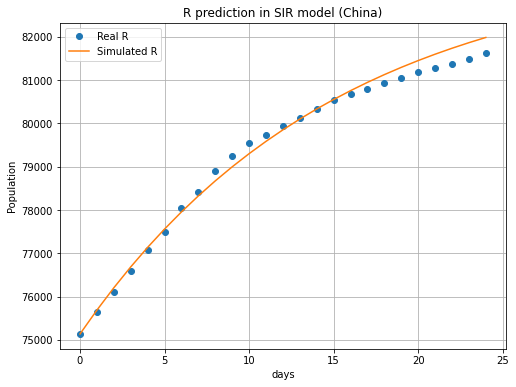

In [137]:
plt.figure(1, figsize=(8,6))
plt.plot(np.arange(0,len(fitted)),r2_d,'o',label='Real R')
plt.plot(np.arange(0,len(fitted)),fitted[:,2],label = 'Simulated R')

plt.xlabel('days')
plt.ylabel('Population')
plt.title('R prediction in SIR model (China)')
plt.legend()
plt.grid()
plt.show()

In [139]:
r2_i = df_china['currentConfirmedCount'].iloc[60:85]
r2_d = df_china['deadCount'].iloc[60:85] + df_china['curedCount'].iloc[60:85]

from sklearn.metrics import r2_score
r2_score(r2_i, fitted[:,1])

0.9358820266381425

In [140]:
r2_score(r2_d, fitted[:,2])

0.9900236351260399

In [142]:
infect = fitted[:,1]
removed = fitted[:,2]
r2_score(r2_i[20:25], infect[20:25])

-1756.977139555741

In [143]:
r2_score(r2_d[20:25], removed[20:25])

-3.92692710133137

## Sensitivity test

In [170]:
infect = Ilist[:20]
suspect = Plist[:20]
quarantine = Qlist[:20]
recover = Rlist[:20]
death = Dlist[:20]

In [171]:
def SEQPIRD_model(Y,t,beta,lambd,delta,kappa,gamma,epilson):
    S,E,Q,P,I,R,D = Y
    N=sum(Y)
    dS = - beta * S * I / N 
    dE = beta * S * I / N  - lambd * E
    dQ = lambd * E - delta * Q
    dP = delta * Q - kappa * P
    dI = kappa * P - gamma * I - epilson * I
    dR = gamma * I
    dD = epilson * I
    return dS,dE,dQ,dP,dI,dR,dD


def fit_odeint_SEQPIRD(t,beta,lambd,delta,kappa,gamma,epilson):
    return integrate.odeint(SEQPIRD_model, ini, t, args=(beta,lambd,delta,kappa,gamma,epilson))


def loss(para):

    beta=para[0]
    lambd=para[1]
    delta=para[2]
    kappa=para[3]
    gamma=para[4]
    epilson=para[5]
    
    T= np.arange(0,len(infect))
    I0 = infect[0]
    # take a guess on the expected population
    P0 = suspect[0]
    Q0 = quarantine[0]
    E0 = Q0/3
    R0 = recover[0]
    D0 = death[0]
    population = 200000
    S0 = population - P0 - Q0 - E0 - I0 - R0 - D0

    # initiate the model
    ini = [S0, E0, Q0, P0, I0, R0, D0] 

    fit_seqpird = integrate.odeint(SEQPIRD_model, ini, T, args=(beta,lambd,delta,kappa,gamma,epilson))
    diffI = fit_seqpird[:,4]-Ilist[20:40]
    diffD = fit_seqpird[:,6]-Dlist[20:40]
    fitloss=1000*np.dot(diffI.T,diffI)+100*np.dot(diffD.T,diffD)
    return fitloss



T= np.arange(0,len(infect))
I0 = infect[0]
P0 = suspect[0]
Q0 = quarantine[0]
E0 = Q0/3
R0 = recover[0]
D0 = death[0]
population = 200000
S0 = population - P0 - Q0 - E0 - I0 - R0 - D0
ini = [S0, E0, Q0, P0, I0, R0, D0] 


methods=['Nelder-Mead','SLSQP','L-BFGS-B','COBYLA','Powell']

beta = 8
lambd = 0.7
delta = 0.4
kappa = 0.2
gamma = 0.8
epilson = 0.5
para=[beta,lambd,delta,kappa,gamma,epilson]

method_name = methods[2]
# bounds are set to aviod outliers that can affect the parameters too much
para= optimize.minimize(loss, para, method=method_name,bounds=[(0,8),(0,1),(0,1),(0,1),(0,1),(0,1)])


# get the fitting data of model
popt=para.x
# theoritical data with future expectation
fitted = fit_odeint_SEQPIRD(np.array(list(range(1,len(infect)+6))), *popt)

In [172]:
popt

array([8.00000000e+00, 6.84348478e-01, 1.00000000e+00, 1.00000000e+00,
       2.66043254e-01, 4.88645904e-03])

In [173]:
# changing beta
#beta,lambd,delta,kappa,gamma,epilson=7.99609372, 1.        , 0.0792842 , 0.41805478, 0.05571859,0.04828965
beta,lambd,delta,kappa,gamma,epilson=8.00000000e+00, 6.84348478e-01, 1.00000000e+00, 1.00000000e+00,2.66043254e-01, 4.88645904e-03
N = 200000
t = np.linspace(0, 30, 30)


def deriv(y, t, N, beta,lambd,delta,kappa,gamma,epilson):
    S,E,Q,P,I,R,D = y
    N = 200000
    dS = - beta * S * I / N 
    dE = beta * S * I / N  - lambd * E
    dQ = lambd * E - delta * Q
    dP = delta * Q - kappa * P
    dI = kappa * P - gamma * I - epilson * I
    dR = gamma * I
    dD = epilson * I
    return dS,dE,dQ,dP,dI,dR,dD

# Initial conditions vector
y0 = S0, E0, Q0, P0, I0, R0, D0
# Integrate the equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta,lambd,delta,kappa,gamma,epilson))
S, E, Q, P, I, R, D = ret.T

In [174]:
# changing beta
#beta,lambd,delta,kappa,gamma,epilson=7.99609372*1.2, 1.        , 0.0792842 , 0.41805478, 0.05571859,0.04828965
beta,lambd,delta,kappa,gamma,epilson=8.00000000e+00*1.2, 6.84348478e-01, 1.00000000e+00, 1.00000000e+00,2.66043254e-01, 4.88645904e-03
N = 200000
t = np.linspace(0, 30, 30)


def deriv(y, t, N, beta,lambd,delta,kappa,gamma,epilson):
    S,E,Q,P,I,R,D = y
    N = 200000
    dS = - beta * S * I / N 
    dE = beta * S * I / N  - lambd * E
    dQ = lambd * E - delta * Q
    dP = delta * Q - kappa * P
    dI = kappa * P - gamma * I - epilson * I
    dR = gamma * I
    dD = epilson * I
    return dS,dE,dQ,dP,dI,dR,dD

# Initial conditions vector
y0 = S0, E0, Q0, P0, I0, R0, D0
# Integrate the equations over the time grid, t.
ret12 = odeint(deriv, y0, t, args=(N, beta,lambd,delta,kappa,gamma,epilson))
S, E, Q, P, I, R, D = ret12.T

In [175]:
# changing beta
#beta,lambd,delta,kappa,gamma,epilson=7.99609372*2, 1.        , 0.0792842 , 0.41805478, 0.05571859,0.04828965      
beta,lambd,delta,kappa,gamma,epilson=8.00000000e+00*2, 6.84348478e-01, 1.00000000e+00, 1.00000000e+00,2.66043254e-01, 4.88645904e-03
N = 200000
t = np.linspace(0, 30, 30)


def deriv(y, t, N, beta,lambd,delta,kappa,gamma,epilson):
    S,E,Q,P,I,R,D = y
    N = 200000
    dS = - beta * S * I / N 
    dE = beta * S * I / N  - lambd * E
    dQ = lambd * E - delta * Q
    dP = delta * Q - kappa * P
    dI = kappa * P - gamma * I - epilson * I
    dR = gamma * I
    dD = epilson * I
    return dS,dE,dQ,dP,dI,dR,dD

# Initial conditions vector
y0 = S0, E0, Q0, P0, I0, R0, D0
# Integrate the equations over the time grid, t.
ret2 = odeint(deriv, y0, t, args=(N, beta,lambd,delta,kappa,gamma,epilson))
S, E, Q, P, I, R, D = ret2.T

In [176]:
# changing beta
#beta,lambd,delta,kappa,gamma,epilson=7.99609372*0.8, 1.        , 0.0792842 , 0.41805478, 0.05571859,0.04828965        
beta,lambd,delta,kappa,gamma,epilson=8.00000000e+00*0.8, 6.84348478e-01, 1.00000000e+00, 1.00000000e+00,2.66043254e-01, 4.88645904e-03
N = 200000
t = np.linspace(0, 30, 30)


def deriv(y, t, N, beta,lambd,delta,kappa,gamma,epilson):
    S,E,Q,P,I,R,D = y
    N = 200000
    dS = - beta * S * I / N 
    dE = beta * S * I / N  - lambd * E
    dQ = lambd * E - delta * Q
    dP = delta * Q - kappa * P
    dI = kappa * P - gamma * I - epilson * I
    dR = gamma * I
    dD = epilson * I
    return dS,dE,dQ,dP,dI,dR,dD

# Initial conditions vector
y0 = S0, E0, Q0, P0, I0, R0, D0
# Integrate the equations over the time grid, t.
ret8 = odeint(deriv, y0, t, args=(N, beta,lambd,delta,kappa,gamma,epilson))
S, E, Q, P, I, R, D = ret8.T

In [177]:
# changing beta
#beta,lambd,delta,kappa,gamma,epilson=7.99609372*0.5, 1.        , 0.0792842 , 0.41805478, 0.05571859,0.04828965 
beta,lambd,delta,kappa,gamma,epilson=8.00000000e+00*0.5, 6.84348478e-01, 1.00000000e+00, 1.00000000e+00,2.66043254e-01, 4.88645904e-03
N = 200000
t = np.linspace(0, 30, 30)


def deriv(y, t, N, beta,lambd,delta,kappa,gamma,epilson):
    S,E,Q,P,I,R,D = y
    N = 200000
    dS = - beta * S * I / N 
    dE = beta * S * I / N  - lambd * E
    dQ = lambd * E - delta * Q
    dP = delta * Q - kappa * P
    dI = kappa * P - gamma * I - epilson * I
    dR = gamma * I
    dD = epilson * I
    return dS,dE,dQ,dP,dI,dR,dD

# Initial conditions vector
y0 = S0, E0, Q0, P0, I0, R0, D0
# Integrate the equations over the time grid, t.
ret5 = odeint(deriv, y0, t, args=(N, beta,lambd,delta,kappa,gamma,epilson))
S, E, Q, P, I, R, D = ret5.T

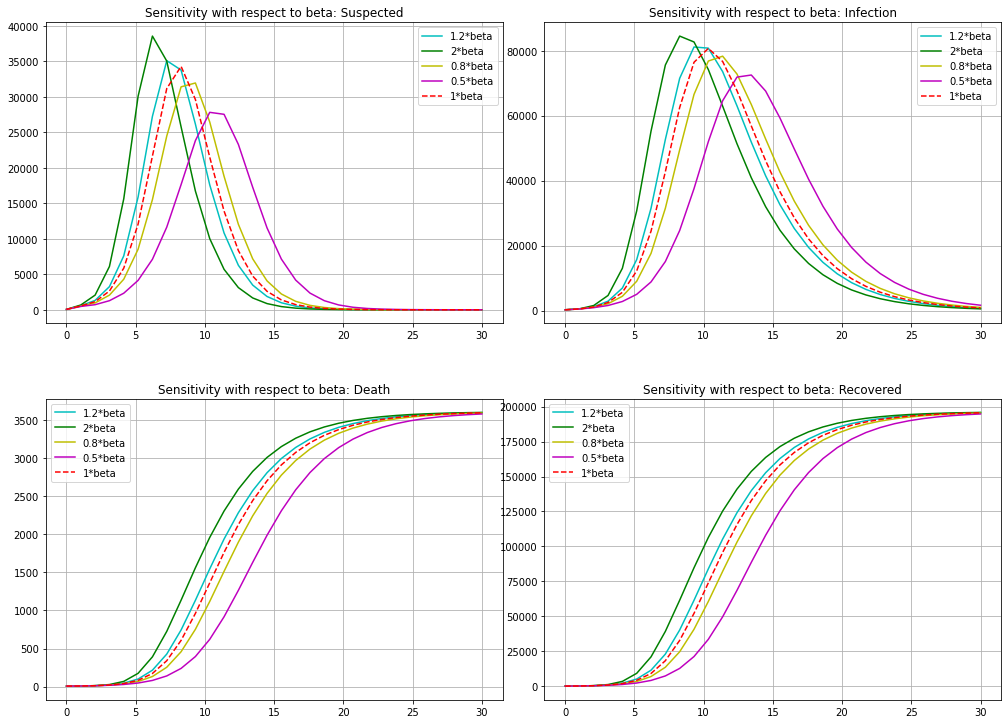

In [178]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14,10))
fig.tight_layout()
fig.subplots_adjust(hspace=0.25)

ax0 = axes[0,0]
ax0.plot(t,ret12[:,3],'c-',label='1.2*beta')
ax0.plot(t,ret2[:,3],'g-',label='2*beta')
ax0.plot(t,ret8[:,3],'y-',label='0.8*beta')
ax0.plot(t,ret5[:,3],'m-',label='0.5*beta')
ax0.plot(t,ret[:,3],'r--',label = '1*beta')
ax0.set_title('Sensitivity with respect to beta: Suspected')
ax0.legend()
ax0.grid()

ax1 = axes[0,1]
ax1.plot(t,ret12[:,4],'c-',label='1.2*beta')
ax1.plot(t,ret2[:,4],'g-',label='2*beta')
ax1.plot(t,ret8[:,4],'y-',label='0.8*beta')
ax1.plot(t,ret5[:,4],'m-',label='0.5*beta')
ax1.plot(t,ret[:,4],'r--',label = '1*beta')
ax1.set_title('Sensitivity with respect to beta: Infection')
ax1.legend()
ax1.grid()

ax2 = axes[1,0]
ax2.plot(t,ret12[:,6],'c-',label='1.2*beta')
ax2.plot(t,ret2[:,6],'g-',label='2*beta')
ax2.plot(t,ret8[:,6],'y-',label='0.8*beta')
ax2.plot(t,ret5[:,6],'m-',label='0.5*beta')
ax2.plot(t,ret[:,6],'r--',label = '1*beta')
ax2.set_title('Sensitivity with respect to beta: Death')
ax2.legend()
ax2.grid()

ax3 = axes[1,1]
ax3.plot(t,ret12[:,5],'c-',label='1.2*beta')
ax3.plot(t,ret2[:,5],'g-',label='2*beta')
ax3.plot(t,ret8[:,5],'y-',label='0.8*beta')
ax3.plot(t,ret5[:,5],'m-',label='0.5*beta')
ax3.plot(t,ret[:,5],'r--',label = '1*beta')
ax3.set_title('Sensitivity with respect to beta: Recovered')
ax3.legend()
ax3.grid()

In [179]:
# changing lambda
beta,lambd,delta,kappa,gamma,epilson=8.00000000e+00, 6.84348478e-01, 1.00000000e+00, 1.00000000e+00,2.66043254e-01, 4.88645904e-03
N = 200000
t = np.linspace(0, 30, 30)


def deriv(y, t, N, beta,lambd,delta,kappa,gamma,epilson):
    S,E,Q,P,I,R,D = y
    N = 200000
    dS = - beta * S * I / N 
    dE = beta * S * I / N  - lambd * E
    dQ = lambd * E - delta * Q
    dP = delta * Q - kappa * P
    dI = kappa * P - gamma * I - epilson * I
    dR = gamma * I
    dD = epilson * I
    return dS,dE,dQ,dP,dI,dR,dD

# Initial conditions vector
y0 = S0, E0, Q0, P0, I0, R0, D0
# Integrate the equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta,lambd,delta,kappa,gamma,epilson))
S, E, Q, P, I, R, D = ret.T

In [180]:
beta,lambd,delta,kappa,gamma,epilson=8.00000000e+00, 6.84348478e-01*1.2, 1.00000000e+00, 1.00000000e+00,2.66043254e-01, 4.88645904e-03
N = 200000
t = np.linspace(0, 30, 30)


def deriv(y, t, N, beta,lambd,delta,kappa,gamma,epilson):
    S,E,Q,P,I,R,D = y
    N = 200000
    dS = - beta * S * I / N 
    dE = beta * S * I / N  - lambd * E
    dQ = lambd * E - delta * Q
    dP = delta * Q - kappa * P
    dI = kappa * P - gamma * I - epilson * I
    dR = gamma * I
    dD = epilson * I
    return dS,dE,dQ,dP,dI,dR,dD

# Initial conditions vector
y0 = S0, E0, Q0, P0, I0, R0, D0
# Integrate the equations over the time grid, t.
ret12 = odeint(deriv, y0, t, args=(N, beta,lambd,delta,kappa,gamma,epilson))
S, E, Q, P, I, R, D = ret12.T

In [181]:
# changing lambda
beta,lambd,delta,kappa,gamma,epilson=8.00000000e+00, 6.84348478e-01*2, 1.00000000e+00, 1.00000000e+00,2.66043254e-01, 4.88645904e-03
N = 200000
t = np.linspace(0, 30, 30)


def deriv(y, t, N, beta,lambd,delta,kappa,gamma,epilson):
    S,E,Q,P,I,R,D = y
    N = 200000
    dS = - beta * S * I / N 
    dE = beta * S * I / N  - lambd * E
    dQ = lambd * E - delta * Q
    dP = delta * Q - kappa * P
    dI = kappa * P - gamma * I - epilson * I
    dR = gamma * I
    dD = epilson * I
    return dS,dE,dQ,dP,dI,dR,dD

# Initial conditions vector
y0 = S0, E0, Q0, P0, I0, R0, D0
# Integrate the equations over the time grid, t.
ret2 = odeint(deriv, y0, t, args=(N, beta,lambd,delta,kappa,gamma,epilson))
S, E, Q, P, I, R, D = ret2.T

In [182]:
# changing lambda
beta,lambd,delta,kappa,gamma,epilson=8.00000000e+00, 6.84348478e-01*0.8, 1.00000000e+00, 1.00000000e+00,2.66043254e-01, 4.88645904e-03
N = 200000
t = np.linspace(0, 30, 30)


def deriv(y, t, N, beta,lambd,delta,kappa,gamma,epilson):
    S,E,Q,P,I,R,D = y
    N = 200000
    dS = - beta * S * I / N 
    dE = beta * S * I / N  - lambd * E
    dQ = lambd * E - delta * Q
    dP = delta * Q - kappa * P
    dI = kappa * P - gamma * I - epilson * I
    dR = gamma * I
    dD = epilson * I
    return dS,dE,dQ,dP,dI,dR,dD

# Initial conditions vector
y0 = S0, E0, Q0, P0, I0, R0, D0
# Integrate the equations over the time grid, t.
ret8 = odeint(deriv, y0, t, args=(N, beta,lambd,delta,kappa,gamma,epilson))
S, E, Q, P, I, R, D = ret8.T

In [183]:
# changing lambda
beta,lambd,delta,kappa,gamma,epilson=8.00000000e+00, 6.84348478e-01*5, 1.00000000e+00, 1.00000000e+00,2.66043254e-01, 4.88645904e-03
N = 200000
t = np.linspace(0, 30, 30)


def deriv(y, t, N, beta,lambd,delta,kappa,gamma,epilson):
    S,E,Q,P,I,R,D = y
    N = 200000
    dS = - beta * S * I / N 
    dE = beta * S * I / N  - lambd * E
    dQ = lambd * E - delta * Q
    dP = delta * Q - kappa * P
    dI = kappa * P - gamma * I - epilson * I
    dR = gamma * I
    dD = epilson * I
    return dS,dE,dQ,dP,dI,dR,dD

# Initial conditions vector
y0 = S0, E0, Q0, P0, I0, R0, D0
# Integrate the equations over the time grid, t.
ret5 = odeint(deriv, y0, t, args=(N, beta,lambd,delta,kappa,gamma,epilson))
S, E, Q, P, I, R, D = ret5.T

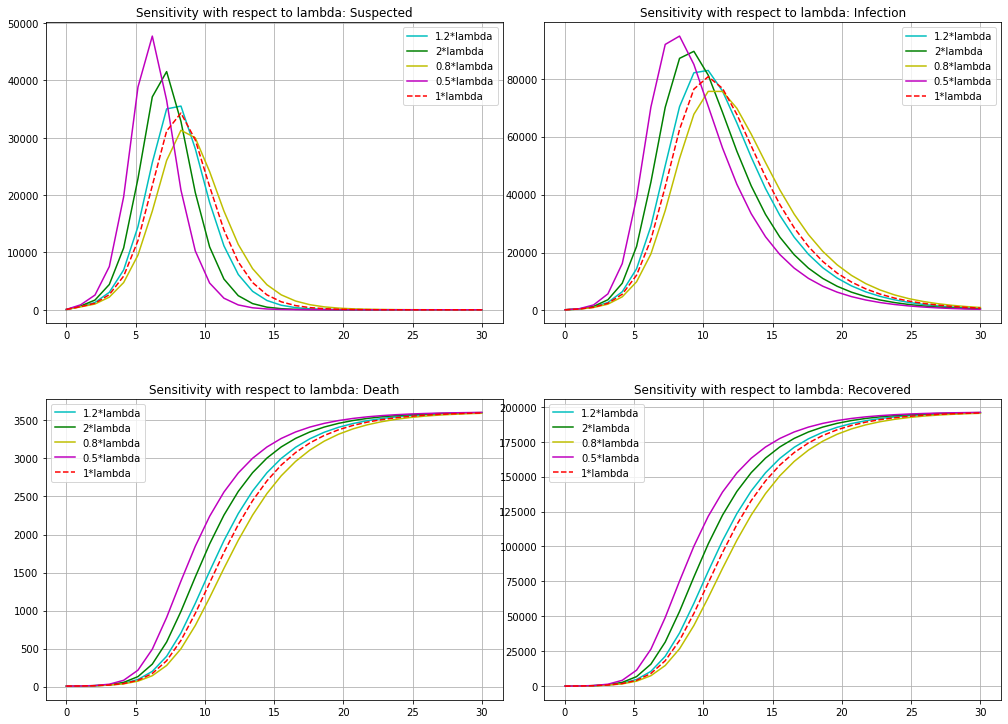

In [185]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14,10))
fig.tight_layout()
fig.subplots_adjust(hspace=0.25)

ax0 = axes[0,0]
ax0.plot(t,ret12[:,3],'c-',label='1.2*lambda')
ax0.plot(t,ret2[:,3],'g-',label='2*lambda')
ax0.plot(t,ret8[:,3],'y-',label='0.8*lambda')
ax0.plot(t,ret5[:,3],'m-',label='0.5*lambda')
ax0.plot(t,ret[:,3],'r--',label = '1*lambda')
ax0.set_title('Sensitivity with respect to lambda: Suspected')
ax0.legend()
ax0.grid()

ax1 = axes[0,1]
ax1.plot(t,ret12[:,4],'c-',label='1.2*lambda')
ax1.plot(t,ret2[:,4],'g-',label='2*lambda')
ax1.plot(t,ret8[:,4],'y-',label='0.8*lambda')
ax1.plot(t,ret5[:,4],'m-',label='0.5*lambda')
ax1.plot(t,ret[:,4],'r--',label = '1*lambda')
ax1.set_title('Sensitivity with respect to lambda: Infection')
ax1.legend()
ax1.grid()

ax2 = axes[1,0]
ax2.plot(t,ret12[:,6],'c-',label='1.2*lambda')
ax2.plot(t,ret2[:,6],'g-',label='2*lambda')
ax2.plot(t,ret8[:,6],'y-',label='0.8*lambda')
ax2.plot(t,ret5[:,6],'m-',label='0.5*lambda')
ax2.plot(t,ret[:,6],'r--',label = '1*lambda')
ax2.set_title('Sensitivity with respect to lambda: Death')
ax2.legend()
ax2.grid()

ax3 = axes[1,1]
ax3.plot(t,ret12[:,5],'c-',label='1.2*lambda')
ax3.plot(t,ret2[:,5],'g-',label='2*lambda')
ax3.plot(t,ret8[:,5],'y-',label='0.8*lambda')
ax3.plot(t,ret5[:,5],'m-',label='0.5*lambda')
ax3.plot(t,ret[:,5],'r--',label = '1*lambda')
ax3.set_title('Sensitivity with respect to lambda: Recovered')
ax3.legend()
ax3.grid()